**Welcome!**

In this notebook, I will provide a brief overview of how you can use the Sentinel-2 and NRCan data we gather in the previous recipes to perform some simple classifications using an off-the-shelf random forest (RF) and a multilayer perceptron (MLP). The performance of these systems is not great, but with further optimization and tuning, you could enhance these classifiers to be much better!

Keep following along in the course to get ideas on how to do this.

In [ ]:
#### Imports

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from matplotlib import cm
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm, Normalize
plt.rcParams.update({'font.size': 30})

Mounted at /content/drive


In [ ]:
#### Constants
BAND_NAMES = ['ndwi', 'ndvi', 'ndsi', 'swir', 'moisture_index', 'true_color']
IMG_TITLES = ['NDWI (B3-B8)/(B3+B8)', 'NDVI (B8-B4)/(B8+B4)', 'NDSI (B3-B11)/(B3+B11)', 'SWIR (B12,8A,B4)', 'Moisture (B8A-B11)/(B8A+B11)', 'True Color (B2,B3,B4)']
LAND_COVER_TYPES = ['Forest', 'Shrubland', 'Wetland', 'Cropland', 'Barren', 'Urban', 'Water']
WIDTH = 2500
HEIGHT = 2181
SITE = 'site1'
SAMPLE_SIZE = 10000

First, we need to load our data as we did last time. Again, I'd recommend using your own datasets for this but if you haven't finished that yet and would still like to follow along, you can use the provided site from my last notebook.

In [ ]:
#### Download site data

# Note: if gdown is not working, please manually download the file and extract it to you Google Drive
# It's a large file (approx. 360 MB) so it may take a minute..
# https://drive.google.com/file/d/10JhKjU7qEwA3L2ltGDDWBU5ND6rOTfVE/view?usp=sharing


!gdown --id '10JhKjU7qEwA3L2ltGDDWBU5ND6rOTfVE'
!unzip '/content/site1.csv.zip' -d '/content'
site_loc = "/content/drive/My Drive/nrcan-ml/data/site1.csv" # Change this to point to site1 on your google drive

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10JhKjU7qEwA3L2ltGDDWBU5ND6rOTfVE
To: /content/site1.csv.zip
100% 357M/357M [00:04<00:00, 75.4MB/s]
Archive:  /content/site1.csv.zip
  inflating: /content/site1.csv      
  inflating: /content/__MACOSX/._site1.csv  


In [ ]:
#### Dataset Structure

df = pd.read_csv(site_loc)  
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452500 entries, 0 to 5452499
Data columns (total 32 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   b01                 float64
 2   b06                 float64
 3   b07                 float64
 4   b11                 float64
 5   b04                 float64
 6   b12                 float64
 7   b8a                 float64
 8   ndwi                float64
 9   ndwi_1              float64
 10  ndwi_1_2            float64
 11  b08                 float64
 12  b09                 float64
 13  ndsi                float64
 14  ndsi_1              float64
 15  ndsi_1_2            float64
 16  moisture_index      float64
 17  moisture_index_1    float64
 18  moisture_index_1_2  float64
 19  b05                 float64
 20  ndvi                float64
 21  ndvi_1              float64
 22  ndvi_1_2            float64
 23  swir                float64
 24  swir_1              floa

,Unnamed: 0,b01,b06,b07,b11,b04,b12,b8a,ndwi,ndwi_1,...,ndvi_1_2,swir,swir_1,swir_1_2,land_cover,b02,true_color,true_color_1,true_color_1_2,b03
0,0,0.0274,0.2010,0.2261,0.1278,0.0385,0.0667,0.2522,0.367163,0.684822,...,0.00,0.16675,0.63050,0.09625,2.0,0.0319,0.09625,0.13400,0.07975,0.0536
1,1,0.0267,0.1815,0.2062,0.1152,0.0301,0.0571,0.2292,0.346457,0.674510,...,0.00,0.14275,0.57300,0.07525,0.0,0.0270,0.07525,0.11475,0.06750,0.0459
2,2,0.0259,0.1905,0.2182,0.1199,0.0357,0.0600,0.2442,0.337617,0.670107,...,0.00,0.15000,0.61050,0.08925,2.0,0.0287,0.08925,0.11975,0.07175,0.0479
3,3,0.0273,0.2068,0.2386,0.1299,0.0433,0.0663,0.2691,0.335075,0.668841,...,0.00,0.16575,0.67275,0.10825,2.0,0.0304,0.10825,0.12850,0.07600,0.0514
4,4,0.0249,0.1653,0.1880,0.0956,0.0240,0.0455,0.2056,0.345806,0.674186,...,0.00,0.11375,0.51400,0.06000,2.0,0.0253,0.06000,0.10400,0.06325,0.0416
5,5,0.0261,0.1698,0.1923,0.1041,0.0266,0.0502,0.2114,0.348592,0.675573,...,0.00,0.12550,0.52850,0.06650,2.0,0.0255,0.06650,0.10575,0.06375,0.0423
6,6,0.0251,0.1582,0.1833,0.1048,0.0302,0.0527,0.2067,0.343416,0.672996,...,0.00,0.13175,0.51675,0.07550,2.0,0.0244,0.07550,0.09900,0.06100,0.0396
7,7,0.0250,0.1887,0.2168,0.1444,0.0385,0.0758,0.2496,0.333333,0.667974,...,0.00,0.18950,0.62400,0.09625,0.0,0.0293,0.09625,0.11750,0.07325,0.0470
8,8,0.0223,0.0710,0.0801,0.0668,0.0235,0.0380,0.0889,0.472727,0.737398,...,0.04,0.09500,0.22225,0.05875,2.0,0.0186,0.05875,0.06250,0.04650,0.0250
9,9,0.0202,0.0610,0.0686,0.0398,0.0175,0.0198,0.0754,0.333952,0.668282,...,0.00,0.04950,0.18850,0.04375,6.0,0.0155,0.04375,0.05050,0.03875,0.0202


Alright, up until now this notebook hasn't changed from the version we saw before. Now that we have our data loaded, let's break it up into training/testing sets and begin doing to ML classification!

In [ ]:
#### Create X and y variables for data splitting

df = df[0:SAMPLE_SIZE]
y = df.land_cover
X = df.drop(['land_cover'], axis=1)
columns = X.columns

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
#### Print out data shapes

print(X.shape)
print(y.shape)

(10000, 31)
(10000,)


To split the data, we will be using scikit-learn's builtin train_test_split function which makes this very easy.

In [ ]:
#### Data splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 31) (2000, 31) (8000,) (2000,)


Up next is to create the ML classifier. We are going to start with a RF. We need to define the classifier (clf), fit it with our training data and then predict against our undseen test data.

In [ ]:
#### Create RF Classifier

clf=RandomForestClassifier(n_estimators=200, max_features='sqrt', min_samples_leaf=2, max_depth=10)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

Let's see how our model did! We can do this using the builtin metrics library from scikit-learn.

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.857


Alright, not bad! I get a result of around 0.859 with my data, however due to the stocastic nature of these methods you might get something slightly different (or completely different with your data). But can we get a better summary of this accuracy? There are a variety of methods for evaluating and interpreting how 'skilled' your model is for classification. We are going to take a look at a standard Confusion Matrix of our predictions of the data at my site.

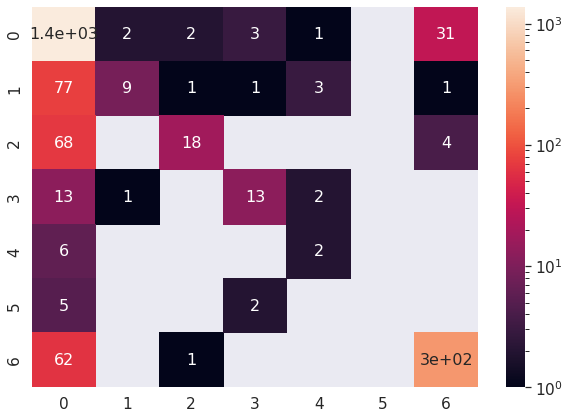

In [ ]:
#### Print Confusion Matrix of RF Results

results = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(results, range(7), range(7))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, norm=LogNorm()) # font size
plt.show()

Okay, this makes a lot of sense. While 86% seems high, it looks like our data is dominated by two land cover types which are skewing the results (0=forest and 6=water). This is a good test to see if you've picked a representative sample to train your model on. We should try to select a dataset with a more balanced and representative sample of the land cover types we are interested in and this was clearly not done here. 

If you are using your data, you may see something completely different!

Before we move on to the MLP, let's take a quick look at the RF feature importance scores. These give some insight into model interpretability (ie. which predictors are providing the most predictive information to the model). It's alright if you don't fully understand this yet, we will cover it in an upcoming recipe on model tuning.

In [ ]:
#### RF Feature Importance Scores

feature_imp = pd.Series(clf.feature_importances_,index=columns).sort_values(ascending=False)
feature_imp

b08                   0.087288
b06                   0.086245
b11                   0.072908
ndsi                  0.068513
b8a                   0.065285
b07                   0.058551
swir_1                0.058333
swir                  0.050810
b09                   0.050656
b12                   0.045689
b05                   0.039566
b04                   0.029592
true_color            0.027147
ndwi_1_2              0.026826
b03                   0.025552
true_color_1_2        0.023975
swir_1_2              0.021507
b01                   0.020979
ndsi_1_2              0.020153
true_color_1          0.019920
ndsi_1                0.017769
b02                   0.016948
moisture_index_1_2    0.015232
Unnamed: 0            0.013694
ndwi_1                0.013299
ndwi                  0.011970
moisture_index_1      0.006134
ndvi                  0.002170
ndvi_1_2              0.002078
ndvi_1                0.000958
moisture_index        0.000253
dtype: float64

Finally, I have put together a very simple toy MLP to see how it's performance fares to the RF we just built.

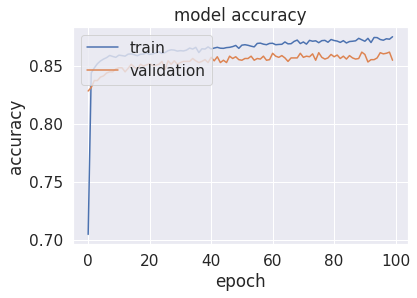

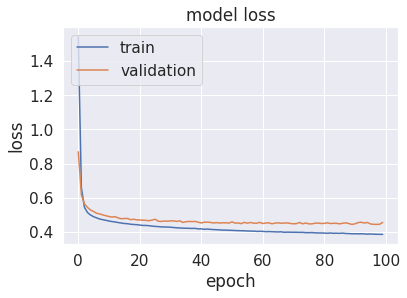

Test loss: 0.4554510712623596
Test accuracy: 0.8550000190734863


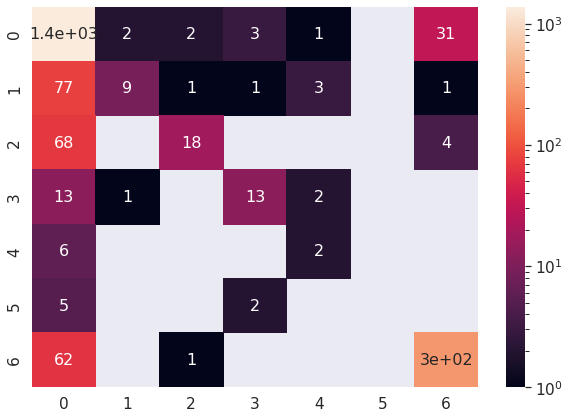

In [ ]:
#### MLP Classifier

def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=31, activation='relu'))
    model.add(Dense(19, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
model = baseline_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), verbose=0, shuffle=True)

# Plot accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Print the score
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

# Plot a confusion matrix
results = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(results, range(7), range(7))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, norm=LogNorm()) # font size
plt.show()

As we can see from this unoptimzed model, the MLP performs very similarly to the RF, with similar predictive error. As an exercise, I'd recommend you making a copy of this notebook and testing these simple classifiers on your own data to get started. 

Additionally, can you enhance the MLP to get better results than your RF? Take a look at the structure we are using here along with the provided hyperparameters. We will talk more about optimizing these methods in an upcoming recipe though so don't worry.

Additionally, if you are interesting in using a CNN for this problem, check out some of the followup recipes which provide additional examples for retaining the spatial structure of the scene.

Great work on finishing another notebook! 